# 视图限制

创建两个相同的面板。在右侧面板上进行缩放时，第一个面板中会显示一个矩形，表示缩放区域。

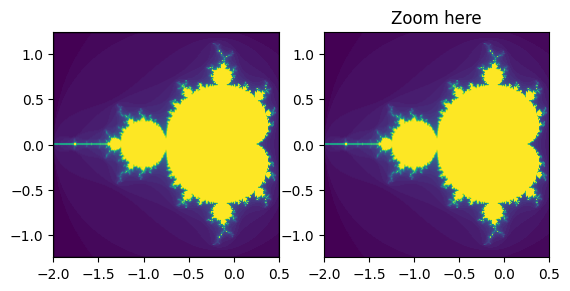

In [1]:
import functools

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Rectangle


# A class that will regenerate a fractal set as we zoom in, so that you
# can actually see the increasing detail.  A box in the left panel will show
# the area to which we are zoomed.
class MandelbrotDisplay:
    def __init__(self, h=500, w=500, niter=50, radius=2., power=2):
        self.height = h
        self.width = w
        self.niter = niter
        self.radius = radius
        self.power = power

    def compute_image(self, xlim, ylim):
        self.x = np.linspace(*xlim, self.width)
        self.y = np.linspace(*ylim, self.height).reshape(-1, 1)
        c = self.x + 1.0j * self.y
        threshold_time = np.zeros((self.height, self.width))
        z = np.zeros(threshold_time.shape, dtype=complex)
        mask = np.ones(threshold_time.shape, dtype=bool)
        for i in range(self.niter):
            z[mask] = z[mask]**self.power + c[mask]
            mask = (np.abs(z) < self.radius)
            threshold_time += mask
        return threshold_time

    def ax_update(self, ax):
        ax.set_autoscale_on(False)  # Otherwise, infinite loop
        # Get the number of points from the number of pixels in the window
        self.width, self.height = ax.patch.get_window_extent().size.round().astype(int)
        # Update the image object with our new data and extent
        ax.images[-1].set(data=self.compute_image(ax.get_xlim(), ax.get_ylim()),
                          extent=(*ax.get_xlim(), *ax.get_ylim()))
        ax.figure.canvas.draw_idle()


md = MandelbrotDisplay()

fig1, (ax_full, ax_zoom) = plt.subplots(1, 2)
ax_zoom.imshow([[0]], origin="lower")  # Empty initial image.
ax_zoom.set_title("Zoom here")

rect = Rectangle(
    [0, 0], 0, 0, facecolor="none", edgecolor="black", linewidth=1.0)
ax_full.add_patch(rect)


def update_rect(rect, ax):  # Let the rectangle track the bounds of the zoom axes.
    xlo, xhi = ax.get_xlim()
    ylo, yhi = ax.get_ylim()
    rect.set_bounds((xlo, ylo, xhi - xlo, yhi - ylo))
    ax.figure.canvas.draw_idle()


# Connect for changing the view limits.
ax_zoom.callbacks.connect("xlim_changed", functools.partial(update_rect, rect))
ax_zoom.callbacks.connect("ylim_changed", functools.partial(update_rect, rect))

ax_zoom.callbacks.connect("xlim_changed", md.ax_update)
ax_zoom.callbacks.connect("ylim_changed", md.ax_update)

# Initialize: trigger image computation by setting view limits; set colormap limits;
# copy image to full view.
ax_zoom.set(xlim=(-2, .5), ylim=(-1.25, 1.25))
im = ax_zoom.images[0]
ax_zoom.images[0].set(clim=(im.get_array().min(), im.get_array().max()))
ax_full.imshow(im.get_array(), extent=im.get_extent(), origin="lower")

plt.show()